In [2]:
import numpy as np
import numpy
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from time import time
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import tensorflow as tf
# tf.enable_eager_execution()

In [4]:
sys.path.append('../code/utils/')
sys.path.append('../code/flowpm/')
import tools
from background import *
import tfpm 
import tfpmfuncs as tfpf
from tfpmconfig import Config


# PM

In [5]:
def pm(config, verbose=False):
    g = tf.Graph()
    with g.as_default():
        linear = tfpm.linfield(config, name='linear')
        icstate = tfpm.lptinit(linear, config, name='icstate')
        fnstate = tfpm.nbody(icstate, config, verbose=verbose, name='fnstate')
        final = tf.zeros_like(linear)
        final = tfpf.cic_paint(final, fnstate[0], boxsize=bs, name='final')
        tf.add_to_collection('pm', [linear, icstate, fnstate, final])
    return g


In [54]:
# pkfile = '../code/flowpm/Planck15_a1p00.txt'
# config = Config(bs=100, nc=32, seed=100, pkfile=pkfile)
# bs, nc = config['boxsize'], config['nc']

# g = pm(config, verbose=True)

# with tf.Session(graph=g) as sess:
#     sess.run(tf.global_variables_initializer())
#     linear = g.get_tensor_by_name('linear:0')
#     final = g.get_tensor_by_name('final:0')
#     fnstate = g.get_tensor_by_name('fnstate:0')
#     icstate = g.get_tensor_by_name('icstate:0')
#     linmesh, finmesh, fstate,istate = sess.run([linear, final, fnstate, icstate])
# #     linmesh, finmesh, fstate,istate = sess.run([linear, final, fnstate, icstate])

# im = plt.imshow(linmesh.sum(axis=0))
# plt.colorbar(im)
# plt.show()
# im = plt.imshow(finmesh.sum(axis=0))
# plt.colorbar(im)
# plt.show()


## Generate Data

In [55]:
#Generate DATA

pkfile = '../code/flowpm/Planck15_a1p00.txt'
config = Config(bs=200, nc=64, seed=100, pkfile=pkfile)
bs, nc = config['boxsize'], config['nc']


tf.reset_default_graph()

g = pm(config)


with tf.Session(graph = g) as sess:
    sess.run(tf.global_variables_initializer())
    linear = g.get_tensor_by_name('linear:0')
    final = g.get_tensor_by_name('final:0')
    truth, final = sess.run([linear, final])
    data = final
    
sigma = 0.01**0.5

np.random.seed(100)
noise = np.random.normal(loc=0, scale=sigma, size=nc**3).reshape(nc, nc, nc).astype(config['dtype'])
datan = data + noise



Text(0.5, 1.0, 'DataN')

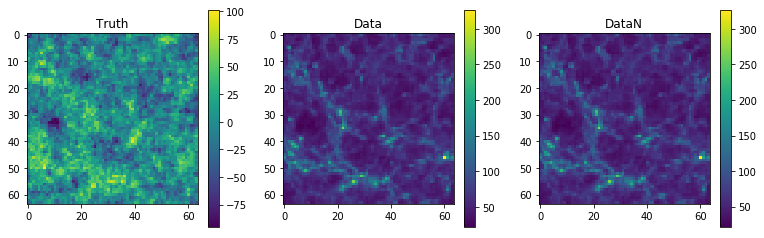

In [56]:
fig, ax = plt.subplots(1, 3, figsize = (13, 4))
im = ax[0].imshow(truth.sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Truth')
im = ax[1].imshow(data.sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Data')
im = ax[2].imshow(datan.sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('DataN')



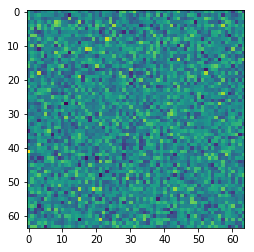

In [57]:
plt.imshow((data-datan).sum(axis=0))

## Diagnostic figure at every nth iteration

In [58]:
# def makefig(truemesh, reconmesh, fname, boxsize, title=''):
#     '''Given a graph, list of 3 fields in truemesh & recon-init                                                                                                                                                                   
#     create the diagnostic figure,  3X3                                                                                                                                                                                            
#     '''
#     truelin, truefin, truedata = truemesh
#     linear, final, data = reconmesh
#     fig, ax = plt.subplots(3, 3, figsize = (12,12))
#     meshes = [[truelin, linear], [truefin, final], [truedata, data]]
#     labels = ['Linear', 'Final', 'Data']
#     for i in range(3):
#         m1, m2 = meshes[i][0], meshes[i][1]
#         if m1.mean() < 1e-2:
#             m1, m2 = m1+1, m2+1
#         k, pt = tools.power(m1, boxsize=boxsize)
#         k, pr = tools.power(m2, boxsize=boxsize)
#         k, px = tools.power(m1, m2, boxsize=boxsize)
#         ax[0, 0].semilogx(k, px/(pr*pt)**.5, 'C%d'%i, label=labels[i])
#         ax[0, 1].semilogx(k, pr/pt, 'C%d'%i)
#         ax[0, 2].loglog(k, pt, 'C%d'%i)
#         ax[0, 2].loglog(k, pr, 'C%d--'%i)
#         ax[1, i].imshow(m2.sum(axis=0))
#         ax[2, i].imshow(m1.sum(axis=0))
#     ax[2, 0].set_ylabel('Truth')
#     ax[1, 0].set_ylabel('Recon')
#     ax[0, 0].set_title('Cross Correlation')
#     ax[0, 0].set_ylim(-0.1, 1.1)
#     ax[0, 1].set_title('Transfer Function')
#     ax[0, 1].set_ylim(-0.1, 2)
#     ax[0, 2].set_title('Powers')
#     ax[0, 2].set_ylim(1, 1e5)
#     ax[0, 0].legend()
#     for axis in ax.flatten(): axis.grid(which='both', lw=0.5, color='gray')
#     fig.suptitle(title)
#     fig.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.show()
# #     fig.savefig(fname)


def makefig(truemesh, reconmesh, fname, boxsize, title=''):
    '''Given a graph, list of 3 fields in truemesh & recon-init                                                                                                                                                                   
    create the diagnostic figure,  3X3                                                                                                                                                                                            
    '''
    truelin, truefin, truedata = truemesh
    linear, final, data = reconmesh
    fig, ax = plt.subplots(2, 3, figsize = (8, 5))
    meshes = [[truelin, linear], [truefin, final], [truedata, data]]
    labels = ['Linear', 'Final', 'Data']
    for i in range(2):
        m1, m2 = meshes[i][0], meshes[i][1]
        if m1.mean() < 1e-2:
            m1, m2 = m1+1, m2+1
        k, pt = tools.power(m1, boxsize=boxsize)
        k, pr = tools.power(m2, boxsize=boxsize)
        k, px = tools.power(m1, m2, boxsize=boxsize)
        ax[0, 0].semilogx(k, px/(pr*pt)**.5, 'C%d'%i, label=labels[i])
        ax[1, 0].semilogx(k, pr/pt, 'C%d'%i)
#         ax[2+i].loglog(k, pt, 'C%d'%i)
#         ax[0, 2].loglog(k, pr, 'C%d--'%i)
        ax[0, 1+i].imshow(m2.sum(axis=0))
        ax[1, 1+i].imshow(m1.sum(axis=0))
    ax[1, 1].set_ylabel('Truth Linear', fontsize=12)
    ax[0, 1].set_ylabel('Recon Linear', fontsize=12)
    ax[1, 2].set_ylabel('Truth Final', fontsize=12)
    ax[0, 2].set_ylabel('Recon Final', fontsize=12)
    ax[0, 0].set_title('Cross Correlation', fontsize=12)
    ax[0, 0].set_ylim(-0.1, 1.1)
    ax[1, 0].set_title('Transfer Function', fontsize=12)
    ax[1, 0].set_ylim(-0.1, 2)
#     ax[0, 2].set_title('Powers')
#     ax[0, 2].set_ylim(1, 1e5)
    ax[0, 0].legend()
    for axis in ax.flatten(): axis.grid(which='both', lw=0.5, color='gray')
#     fig.suptitle(title)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
#     fig.savefig(fname)


## Scipy LBFGS recon with Tflow

In [46]:
from tensorflow.contrib.opt import ScipyOptimizerInterface

def graphdm(config, data, sigma=0.01**0.5, maxiter=100, anneal=False, dataovd=False, gtol=1e-5):

    bs, nc = config['boxsize'], config['nc']
    kmesh = sum(kk**2 for kk in config['kvec'])**0.5
    priorwt = config['ipklin'](kmesh) * bs ** -3

    g = tf.Graph()

    with g.as_default():

        initlin = tf.placeholder(tf.float32, data.shape, name='initlin')
        linear = tf.get_variable('linmesh', shape=(nc, nc, nc),
                             initializer=tf.random_normal_initializer(), trainable=True)
        initlin_op = linear.assign(initlin, name='initlin_op')
        #PM                                                                                                                                                                                                                       
        icstate = tfpm.lptinit(linear, config, name='icstate')
        fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
        final = tf.zeros_like(linear)
        final = tfpf.cic_paint(final, fnstate[0], boxsize=bs, name='final')
        if dataovd:
            print('\Converting final density to overdensity because data is that\n')
            fmean = tf.reduce_mean(final)
            final = tf.multiply(final, 1/ fmean)
            final = final - 1
            
        #   
              #                                                                                                                                                                                                                         
        #Prior                                                                                                                                                                                                                    
        lineark = tfpf.r2c3d(linear, norm=nc**3)
        priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
        prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt))
        prior = tf.multiply(prior, 1/nc**3, name='prior')

        likelihood = tf.subtract(final, data)
        likelihood = tf.multiply(likelihood, 1/sigma)
        ##Anneal                                                                                                                                                                                                                  
        Rsm = tf.placeholder(tf.float32, name='smoothing')

        #annealing is smoothing the difference, before squaring, with gaussian smoothing
        if anneal :
            print('\nAdding annealing part to graph\n')
            Rsm = tf.multiply(Rsm, bs/nc)
            Rsmsq = tf.multiply(Rsm, Rsm)
            smwts = tf.exp(tf.multiply(-kmesh**2, Rsmsq))
            likelihood = tf.squeeze(likelihood)
            likelihoodk = tfpf.r2c3d(likelihood, norm=nc**3)
            likelihoodk = tf.multiply(likelihoodk, tf.cast(smwts, tf.complex64))
            residual = tfpf.c2r3d(likelihoodk, norm=nc**3)
        else:
            residual = tf.identity(likelihood)

        chisq = tf.multiply(residual, residual)
        chisq = tf.reduce_sum(chisq)
        chisq = tf.multiply(chisq, 1/nc**3, name='chisq')

        loss = tf.add(chisq, prior, name='loss')
           
        optimizer = ScipyOptimizerInterface(loss, var_list=[linear], method='L-BFGS-B',
                                            options={'maxiter': maxiter, 'gtol':gtol})

        tf.add_to_collection('inits', [initlin_op, initlin])
        tf.add_to_collection('opt', optimizer)
        tf.add_to_collection('diagnostics', [prior, chisq, loss])
        tf.add_to_collection('reconpm', [linear, final, fnstate])
        tf.add_to_collection('data', data)
    return g


## With annealing


Adding annealing part to graph


########## Anneal for Rsm = 4.00 ##########


Checking mode = init



/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


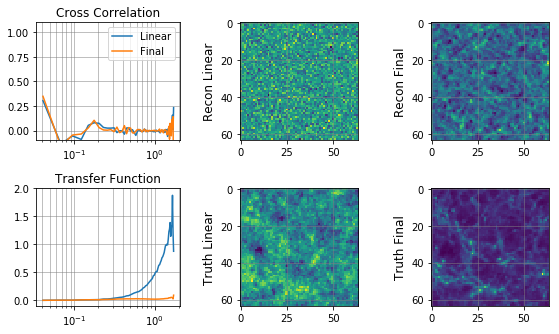

Time taken for iterations 0 =  38.08870315551758
Iteration no. :  0  - Loss, chisq, prior, grad :  [4.366634, 3.8945842, 0.47204965, 0.049692452]


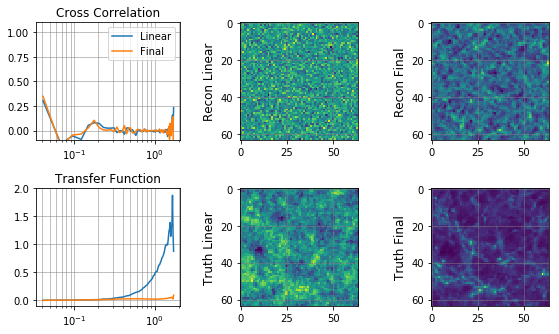

Time taken for iterations 10 =  45.81355595588684
Iteration no. :  10  - Loss, chisq, prior, grad :  [0.3598464, 0.06100767, 0.29883873, 0.0033632417]


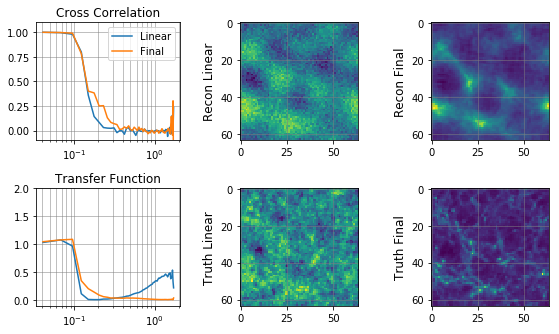

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.067728
  Number of iterations: 17
  Number of functions evaluations: 20

Checking mode = recon



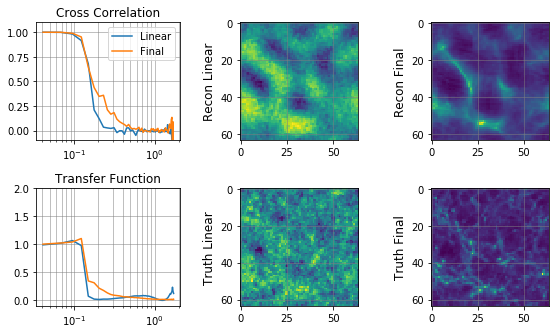


########## Anneal for Rsm = 2.00 ##########


Checking mode = init



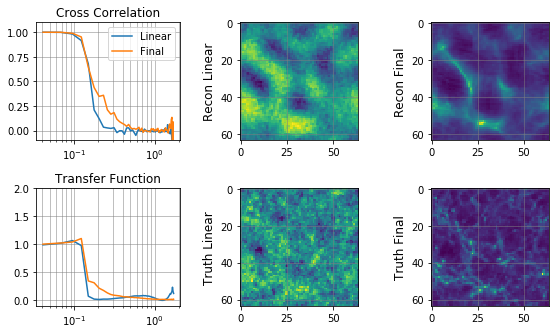

Time taken for iterations 0 =  58.89316487312317
Iteration no. :  0  - Loss, chisq, prior, grad :  [2.4702559, 2.4249187, 0.045337252, 0.028183686]


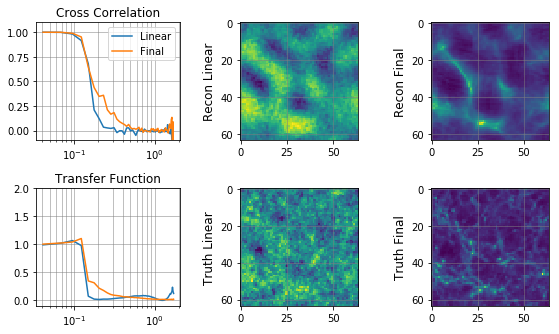

Time taken for iterations 10 =  66.56495642662048
Iteration no. :  10  - Loss, chisq, prior, grad :  [0.29599643, 0.25348112, 0.042515293, 0.006301258]


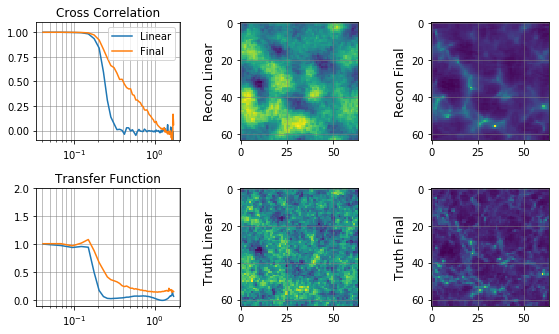

Time taken for iterations 20 =  74.62018322944641
Iteration no. :  20  - Loss, chisq, prior, grad :  [0.09432495, 0.06039484, 0.03393011, 0.002165604]


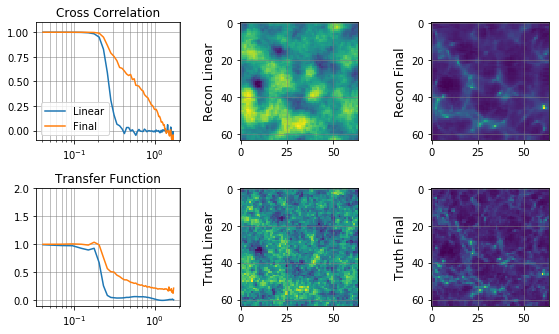

Time taken for iterations 30 =  82.56266188621521
Iteration no. :  30  - Loss, chisq, prior, grad :  [0.0529591, 0.028092023, 0.024867078, 0.0013774539]


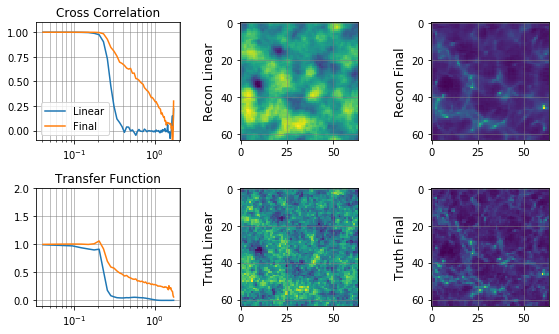

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.044737
  Number of iterations: 29
  Number of functions evaluations: 34

Checking mode = recon



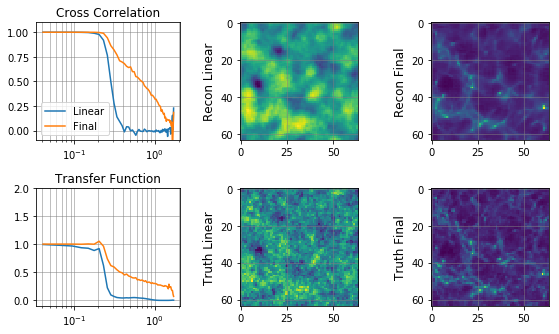


########## Anneal for Rsm = 1.00 ##########


Checking mode = init



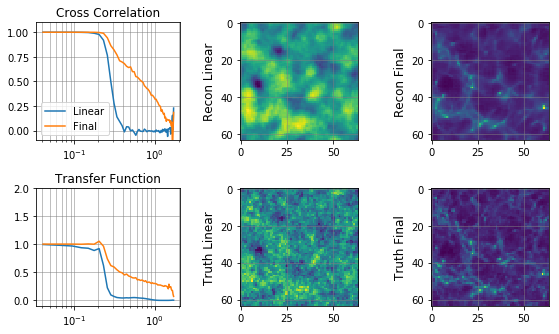

Time taken for iterations 0 =  91.64854693412781
Iteration no. :  0  - Loss, chisq, prior, grad :  [3.402205, 3.3803582, 0.021846851, 0.040997695]


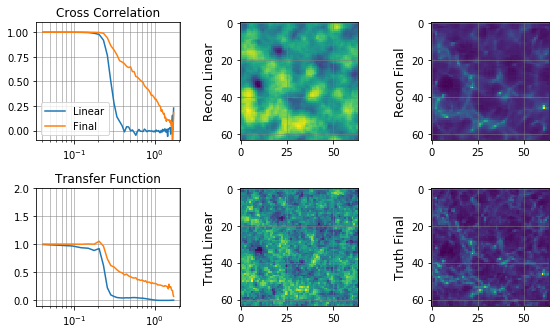

Time taken for iterations 10 =  99.49733114242554
Iteration no. :  10  - Loss, chisq, prior, grad :  [0.90800476, 0.8811724, 0.02683235, 0.02323567]


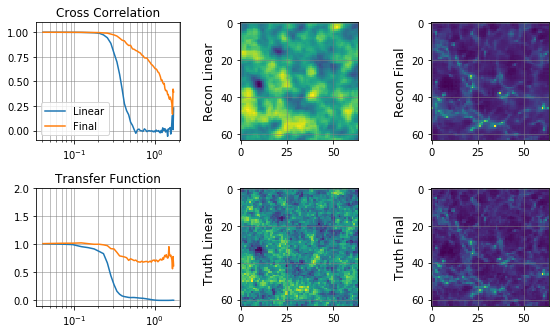

Time taken for iterations 20 =  107.4189772605896
Iteration no. :  20  - Loss, chisq, prior, grad :  [0.36571234, 0.33377182, 0.03194051, 0.009931537]


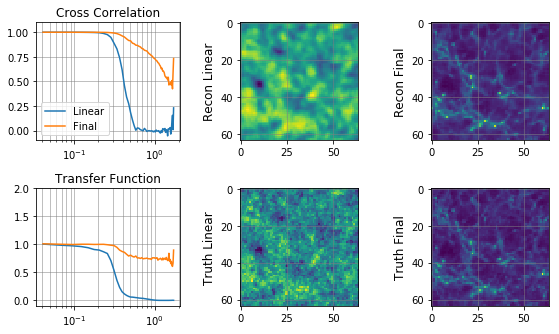

Time taken for iterations 30 =  116.46119284629822
Iteration no. :  30  - Loss, chisq, prior, grad :  [0.20499507, 0.16906428, 0.035930775, 0.0056843227]


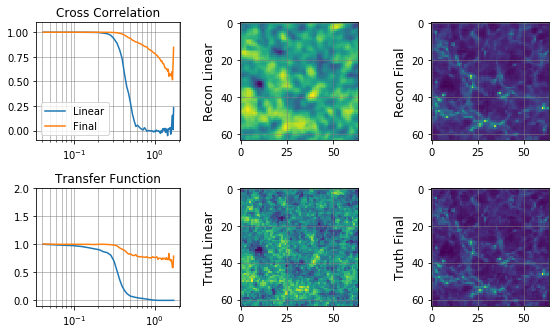

Time taken for iterations 40 =  124.42386436462402
Iteration no. :  40  - Loss, chisq, prior, grad :  [0.14047284, 0.10121612, 0.039256725, 0.00408601]


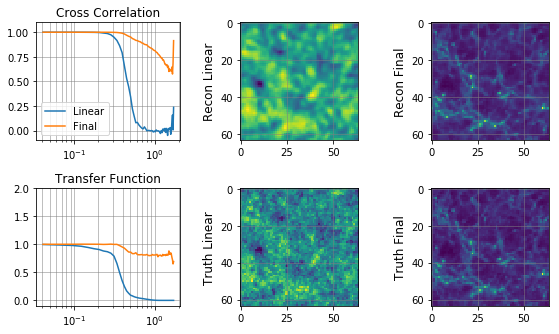

Time taken for iterations 50 =  132.395085811615
Iteration no. :  50  - Loss, chisq, prior, grad :  [0.11334138, 0.07149732, 0.041844063, 0.010401799]


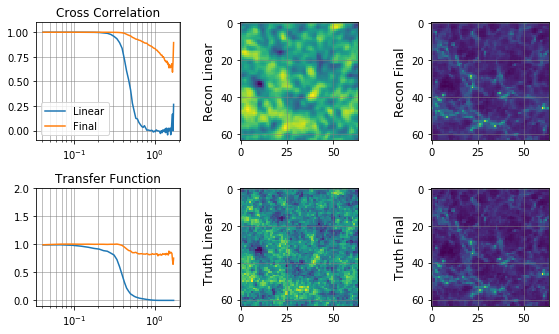

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 0.107208
  Number of iterations: 50
  Number of functions evaluations: 53

Checking mode = recon



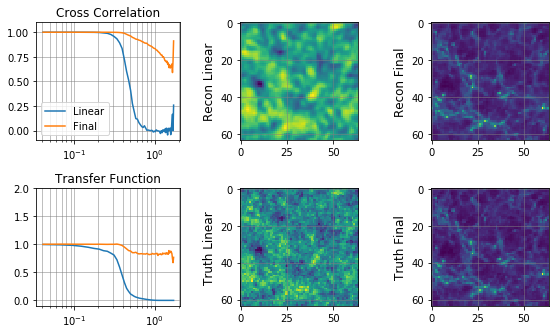


########## Anneal for Rsm = 0.00 ##########


Checking mode = init



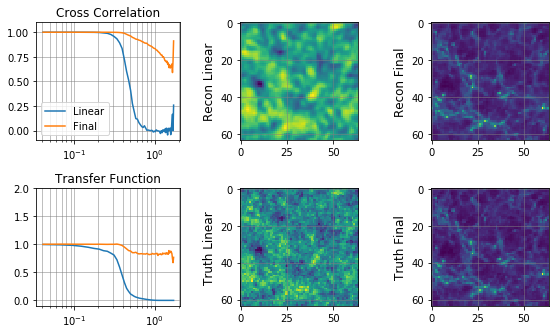

Time taken for iterations 0 =  140.84497594833374
Iteration no. :  0  - Loss, chisq, prior, grad :  [41.078377, 41.036716, 0.04166138, 1.4312657]


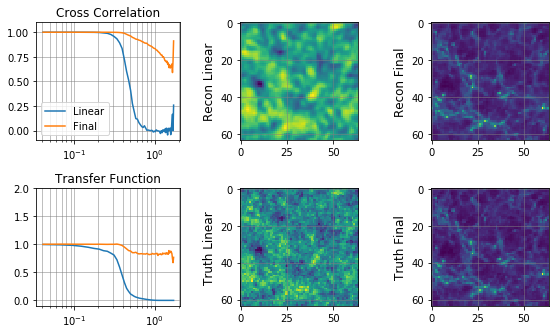

Time taken for iterations 10 =  148.62579607963562
Iteration no. :  10  - Loss, chisq, prior, grad :  [25.642698, 25.599722, 0.04297624, 1.359659]


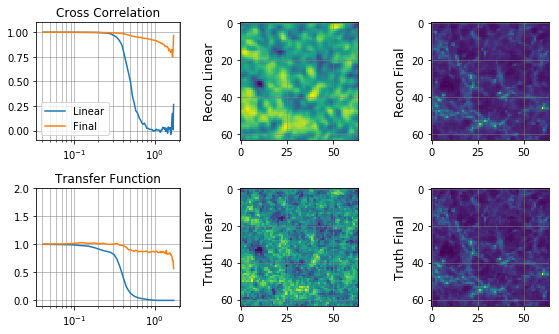

Time taken for iterations 20 =  156.68300080299377
Iteration no. :  20  - Loss, chisq, prior, grad :  [17.134907, 17.088417, 0.046490528, 0.5216953]


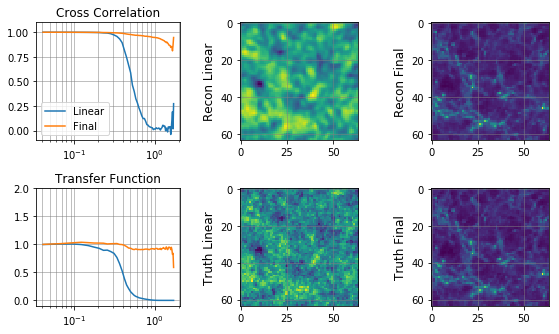

Time taken for iterations 30 =  164.63229894638062
Iteration no. :  30  - Loss, chisq, prior, grad :  [12.604124, 12.551978, 0.052146107, 0.24205106]


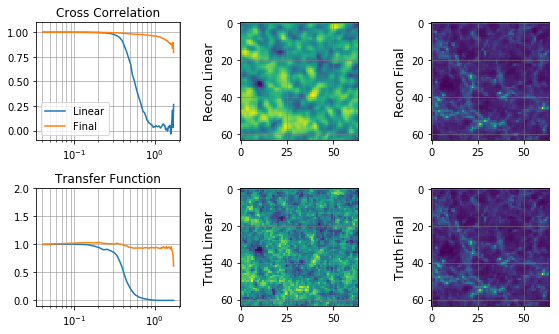

Time taken for iterations 40 =  172.60319066047668
Iteration no. :  40  - Loss, chisq, prior, grad :  [9.688257, 9.6303625, 0.05789485, 0.3546879]


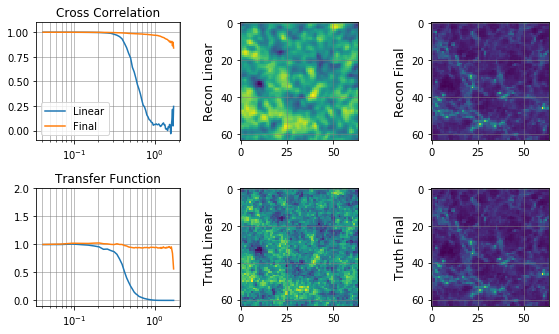

Time taken for iterations 50 =  180.56599354743958
Iteration no. :  50  - Loss, chisq, prior, grad :  [7.483544, 7.416979, 0.06656493, 0.2596976]


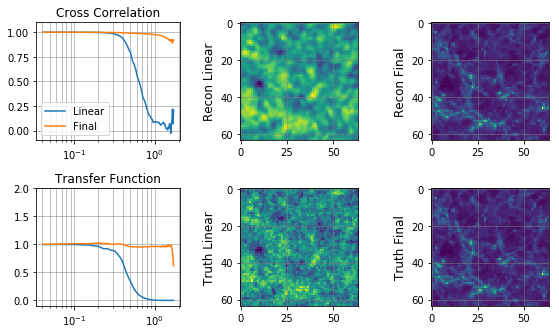

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 7.483544
  Number of iterations: 50
  Number of functions evaluations: 51

Checking mode = recon



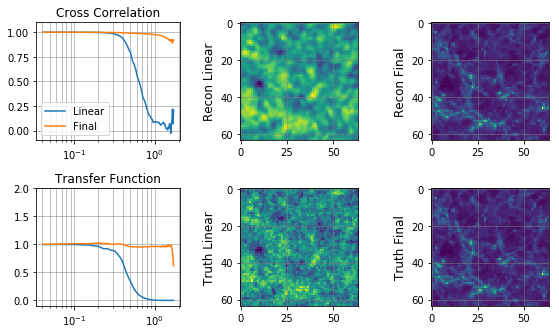

In [59]:
anneal = True
truemeshes = [truth, data, datan]

maxiter = 50
nprint, nsave = 10, 10

def loss_callback(var, literals, nprint=50, nsave=50, maxiter=500, t0=time()):
    losses = literals['losses']
    loss = var[0]
    reconmeshes = var[1]
    nit = len(losses) %(maxiter+10)
    losses.append(loss)
    if nit % nprint == 0:
        print('Time taken for iterations %d = '%nit, time() - t0)
        print('Iteration no. : ', nit, " - Loss, chisq, prior, grad : ", loss)

        fname = None
        stime = time()
        makefig(literals['truemeshes'], reconmeshes, fname, boxsize=bs, title='%s'%loss)


 
initval = None
#initval = np.random.normal(1, 0.5, size=nc**3).reshape(nc, nc, nc).astype(config['dtype'])#truth                                                                                                                             
#initval = standardinit(config, data, hposd, final, R=8)                                                                                                                                                                      
#initval = tools.readbigfile(dpath + ftype%(bs, nc, 900, step) + 'mesh/s/')                                                                                                                                                   
#initval = np.ones((nc, nc, nc))                                                                                                                                                                                              
#initval = truth.copy()                                                                                                                                                                                                       


losses = []
literals = {'losses':losses, 'truemeshes':truemeshes, 'bs':bs, 'nc':nc}
tstart = time()
lcallback = lambda x: loss_callback(x, literals=literals, nprint=nprint, nsave=nsave, maxiter=maxiter, t0=tstart)
R0s = [4, 2, 1, 0]

#
recong = graphdm(config, data, maxiter=maxiter, anneal=anneal)
reconfieldsanneal = []

with tf.Session(graph=recong) as session:
    g = session.graph
    session.run(tf.global_variables_initializer())
    linmesh = g.get_tensor_by_name("linmesh:0")
    final = g.get_tensor_by_name("final:0")
    samples = final
    optimizer = g.get_collection_ref('opt')[0]
    loss = g.get_tensor_by_name('loss:0')
    chisq = g.get_tensor_by_name('chisq:0')
    grad = tf.norm(tf.gradients(loss, linmesh))
    prior = g.get_tensor_by_name('prior:0')
    Rsm = g.get_tensor_by_name('smoothing:0')

    if initval is not None:
        print('Do init')
        initlinop = g.get_operation_by_name('initlin_op')
        initlin = g.get_tensor_by_name('initlin:0')
        session.run(initlinop, {initlin:initval})


    def checkiter(mode, optfolder=None, R0=0):
        print('\nChecking mode = %s\n'%mode)
        meshs, meshf, meshd = session.run([linmesh, final, samples], {Rsm:R0})
        title = session.run([loss, chisq, prior, grad], {Rsm:R0})
#         np.save(optfolder + '/%s%d.f4'%(mode, R0), meshs)
        makefig(literals['truemeshes'], [meshs, meshf, meshd], None, 
                   boxsize=bs, title='%s'%title)

    if anneal:

        for R0 in R0s:
            literals = {'losses':[], 'truemeshes':truemeshes, 'bs':bs, 'nc':nc}
            optfolder = None
            print('\n########## Anneal for Rsm = %0.2f ##########\n'%R0)

            checkiter('init', optfolder, R0=R0)
            optimizer.minimize(session, {Rsm:R0}, loss_callback=lcallback, fetches=[[[loss, chisq, prior, grad], \
                                                                       [linmesh, final, samples]]])
            checkiter('recon', optfolder, R0=R0)
            reconfieldsanneal.append(session.run(linmesh, {Rsm:R0}))

    else:
        optfolder = None
        print('\n########## No annealing ##########\n')

        checkiter('init', optfolder, R0=0)
        optimizer.minimize(session, loss_callback=lcallback, fetches=[[[loss, chisq, prior, grad], \
                                                                       [linmesh, final, samples]]])
        checkiter('recon', optfolder, R0=0)
#         reconfields.append(session.run(linmesh, {Rsm:R0}))
#         #                                                                                                                                                                                                                     




## Without annealing


########## No annealing ##########


Checking mode = init



/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


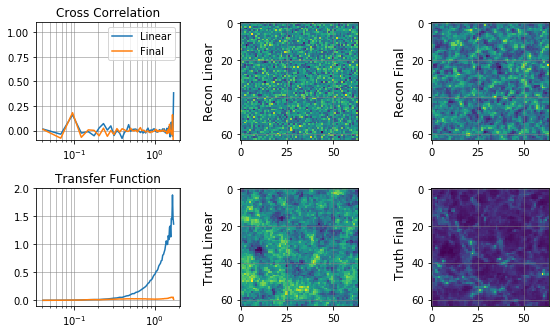

Time taken for iterations 0 =  37.58942413330078
Iteration no. :  0  - Loss, chisq, prior, grad :  [359.07593, 358.60223, 0.47370535, 0.4894302]


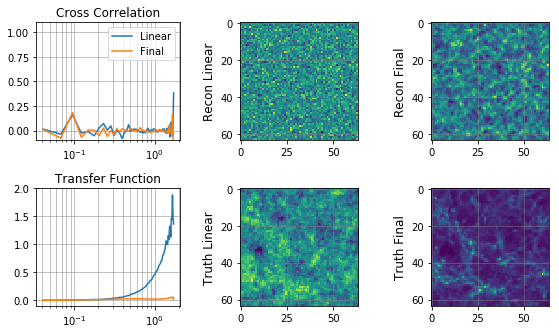

Time taken for iterations 10 =  45.19315814971924
Iteration no. :  10  - Loss, chisq, prior, grad :  [210.4682, 209.99014, 0.47805583, 1.3721184]


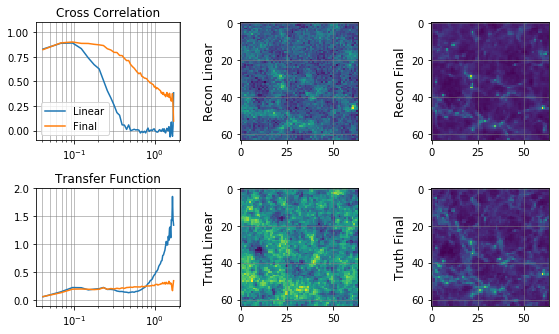

Time taken for iterations 20 =  53.053616523742676
Iteration no. :  20  - Loss, chisq, prior, grad :  [95.586784, 95.08829, 0.49849856, 1.0217314]


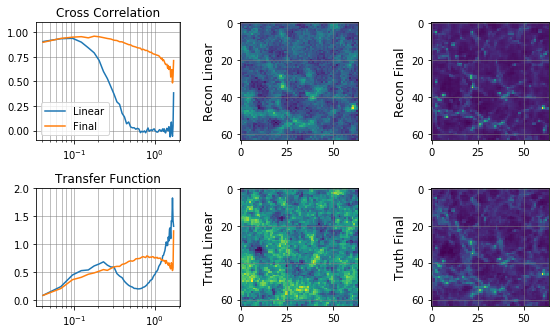

Time taken for iterations 30 =  60.943984508514404
Iteration no. :  30  - Loss, chisq, prior, grad :  [58.28347, 57.772522, 0.5109484, 0.9111004]


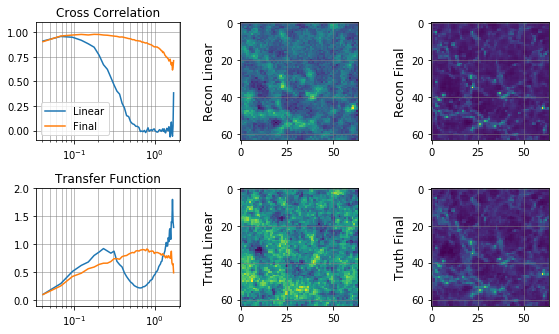

Time taken for iterations 40 =  68.85253620147705
Iteration no. :  40  - Loss, chisq, prior, grad :  [40.502617, 39.982117, 0.5205006, 0.48579636]


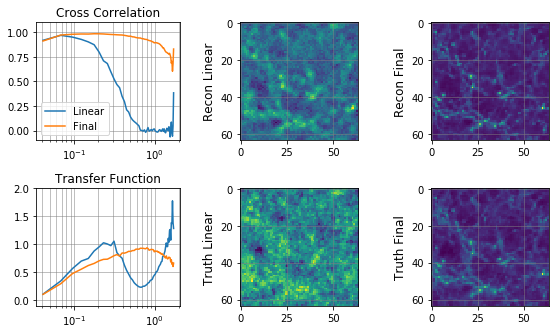

Time taken for iterations 50 =  76.74363350868225
Iteration no. :  50  - Loss, chisq, prior, grad :  [32.048218, 31.519974, 0.52824235, 0.29111415]


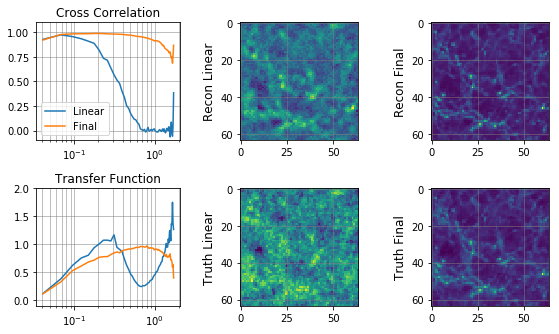

Time taken for iterations 60 =  84.62014245986938
Iteration no. :  60  - Loss, chisq, prior, grad :  [25.69003, 25.152802, 0.5372272, 0.68028647]


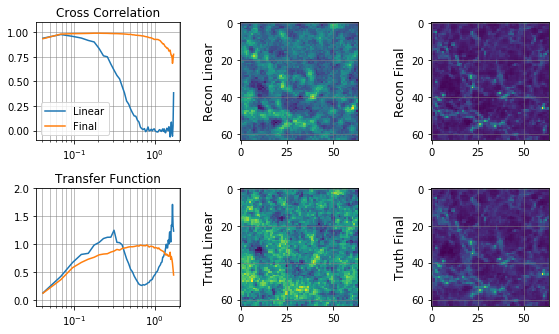

Time taken for iterations 70 =  92.45511865615845
Iteration no. :  70  - Loss, chisq, prior, grad :  [21.745968, 21.200733, 0.54523504, 0.4911577]


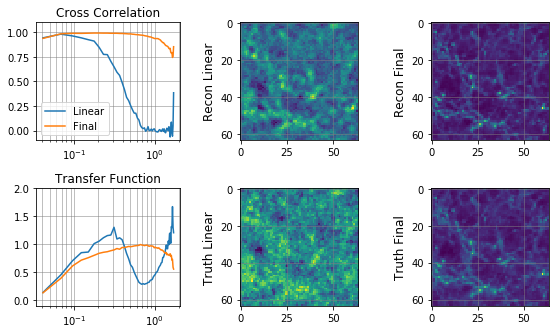

Time taken for iterations 80 =  100.46703958511353
Iteration no. :  80  - Loss, chisq, prior, grad :  [18.641264, 18.09019, 0.55107236, 0.19592467]


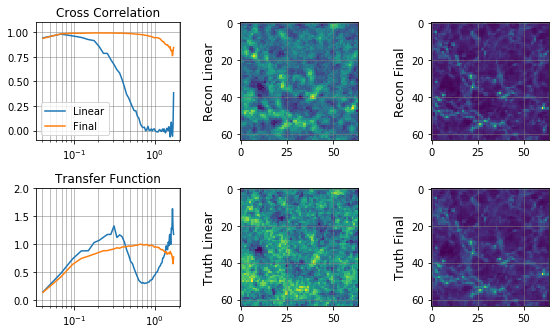

Time taken for iterations 90 =  108.35080409049988
Iteration no. :  90  - Loss, chisq, prior, grad :  [16.45663, 15.901053, 0.5555767, 0.19933537]


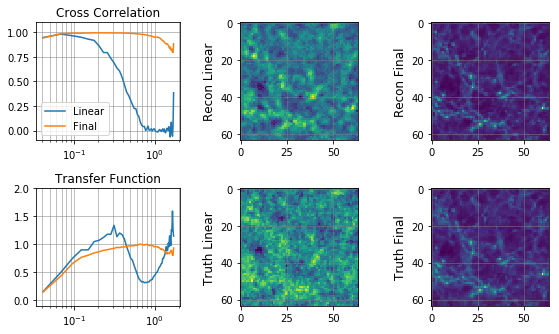

Time taken for iterations 100 =  116.25209140777588
Iteration no. :  100  - Loss, chisq, prior, grad :  [14.716471, 14.155717, 0.560754, 0.17962673]


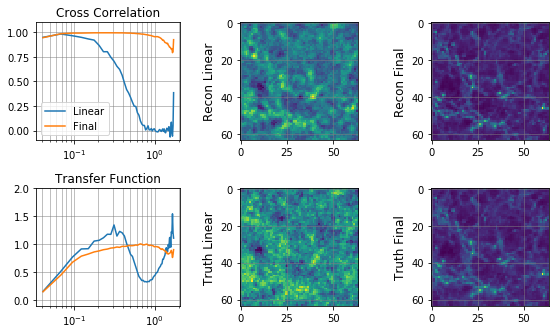

Time taken for iterations 110 =  124.1436939239502
Iteration no. :  110  - Loss, chisq, prior, grad :  [13.421549, 12.856911, 0.56463826, 0.15218867]


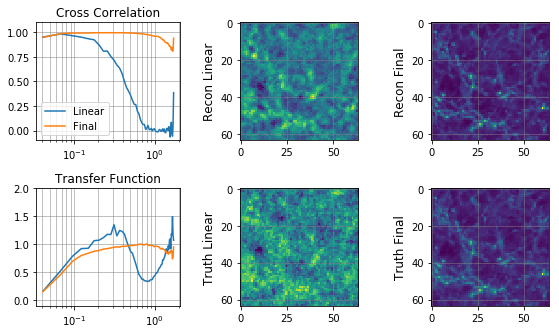

Time taken for iterations 120 =  132.00564336776733
Iteration no. :  120  - Loss, chisq, prior, grad :  [12.230529, 11.661673, 0.56885624, 0.13509482]


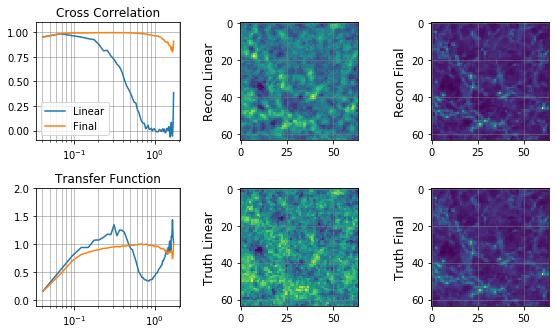

Time taken for iterations 130 =  139.94047141075134
Iteration no. :  130  - Loss, chisq, prior, grad :  [11.308438, 10.735693, 0.5727453, 0.10639559]


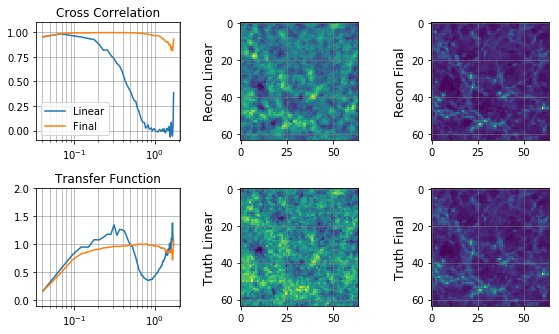

Time taken for iterations 140 =  147.9758198261261
Iteration no. :  140  - Loss, chisq, prior, grad :  [10.587009, 10.009399, 0.57761014, 0.18294218]


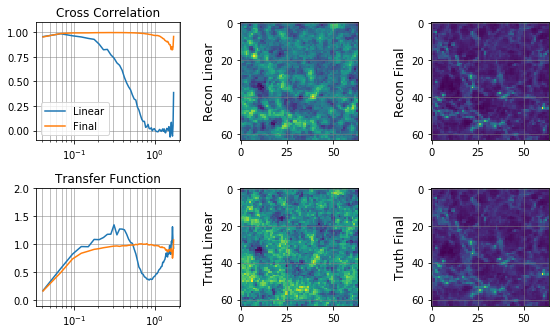

Time taken for iterations 150 =  155.8886616230011
Iteration no. :  150  - Loss, chisq, prior, grad :  [9.9781, 9.395182, 0.5829179, 0.26255667]


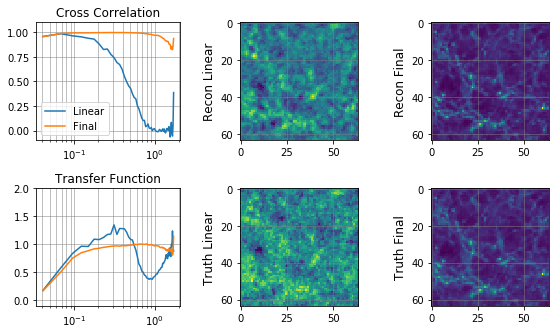

Time taken for iterations 160 =  163.7998652458191
Iteration no. :  160  - Loss, chisq, prior, grad :  [9.463378, 8.875531, 0.5878467, 0.07500422]


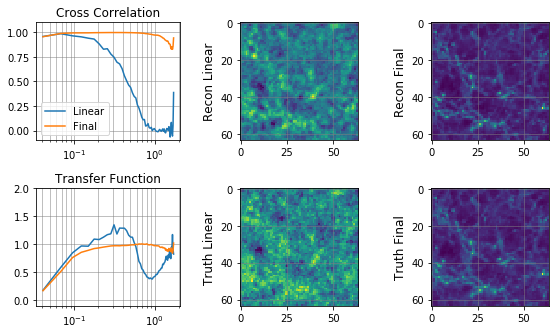

Time taken for iterations 170 =  171.68780255317688
Iteration no. :  170  - Loss, chisq, prior, grad :  [9.044566, 8.452145, 0.59242123, 0.087434635]


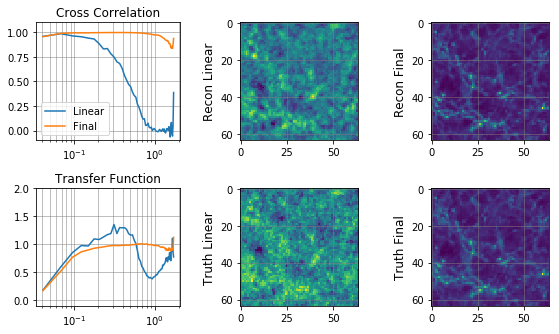

Time taken for iterations 180 =  179.62294602394104
Iteration no. :  180  - Loss, chisq, prior, grad :  [8.622798, 8.026658, 0.5961398, 0.08909391]


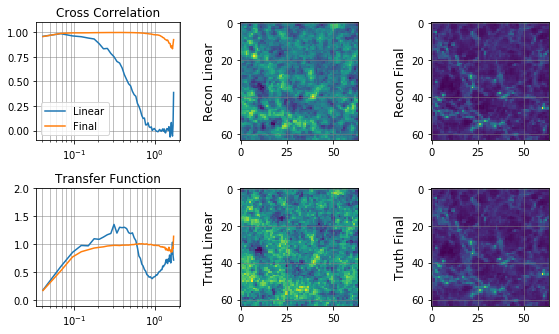

Time taken for iterations 190 =  187.51531767845154
Iteration no. :  190  - Loss, chisq, prior, grad :  [8.290382, 7.691973, 0.5984094, 0.059404455]


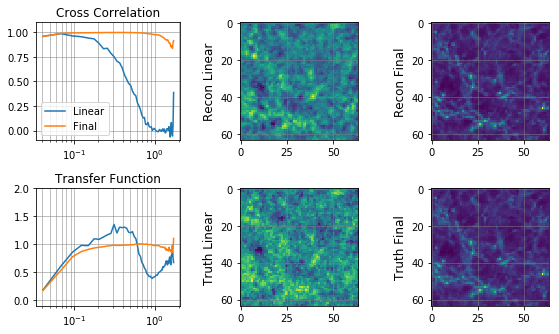

Time taken for iterations 200 =  195.42289638519287
Iteration no. :  200  - Loss, chisq, prior, grad :  [8.001743, 7.4005103, 0.6012333, 0.07126077]


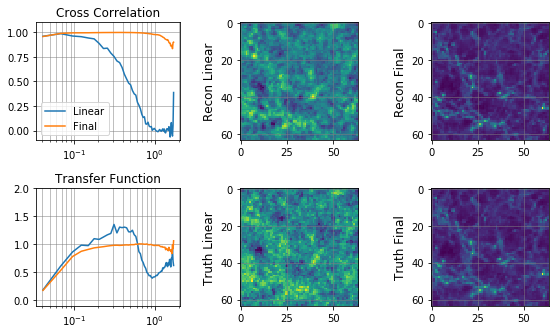

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 7.823004
  Number of iterations: 200
  Number of functions evaluations: 208

Checking mode = recon



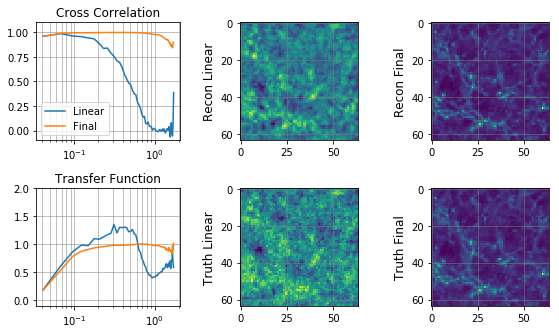

In [60]:
anneal = False
truemeshes = [truth, data, datan]

maxiter = 200
nprint, nsave = 10, 10

def loss_callback(var, literals, nprint=50, nsave=50, maxiter=500, t0=time()):
    losses = literals['losses']
    loss = var[0]
    reconmeshes = var[1]
    nit = len(losses) %(maxiter+10)
    losses.append(loss)
    if nit % nprint == 0:
        print('Time taken for iterations %d = '%nit, time() - t0)
        print('Iteration no. : ', nit, " - Loss, chisq, prior, grad : ", loss)

        fname = None
        stime = time()
        makefig(literals['truemeshes'], reconmeshes, fname, boxsize=bs, title='%s'%loss)


 
initval = None
losses = []
literals = {'losses':losses, 'truemeshes':truemeshes, 'bs':bs, 'nc':nc}
tstart = time()
lcallback = lambda x: loss_callback(x, literals=literals, nprint=nprint, nsave=nsave, maxiter=maxiter, t0=tstart)
R0s = [4, 2, 1, 0]

#
recong = graphdm(config, data, maxiter=maxiter, anneal=anneal)
reconfields = []

with tf.Session(graph=recong) as session:
    g = session.graph
    session.run(tf.global_variables_initializer())
    linmesh = g.get_tensor_by_name("linmesh:0")
    final = g.get_tensor_by_name("final:0")
    samples = final
    optimizer = g.get_collection_ref('opt')[0]
    loss = g.get_tensor_by_name('loss:0')
    chisq = g.get_tensor_by_name('chisq:0')
    grad = tf.norm(tf.gradients(loss, linmesh))
    prior = g.get_tensor_by_name('prior:0')
    Rsm = g.get_tensor_by_name('smoothing:0')

    if initval is not None:
        print('Do init')
        initlinop = g.get_operation_by_name('initlin_op')
        initlin = g.get_tensor_by_name('initlin:0')
        session.run(initlinop, {initlin:initval})


    def checkiter(mode, optfolder=None, R0=0):
        print('\nChecking mode = %s\n'%mode)
        meshs, meshf, meshd = session.run([linmesh, final, samples], {Rsm:R0})
        title = session.run([loss, chisq, prior, grad], {Rsm:R0})
#         np.save(optfolder + '/%s%d.f4'%(mode, R0), meshs)
        makefig(literals['truemeshes'], [meshs, meshf, meshd], None, 
                   boxsize=bs, title='%s'%title)

    if anneal:

        for R0 in R0s:
            literals = {'losses':[], 'truemeshes':truemeshes, 'bs':bs, 'nc':nc}
            optfolder = None
            print('\n########## Anneal for Rsm = %0.2f ##########\n'%R0)

            checkiter('init', optfolder, R0=R0)
            optimizer.minimize(session, {Rsm:R0}, loss_callback=lcallback, fetches=[[[loss, chisq, prior, grad], \
                                                                       [linmesh, final, samples]]])
            checkiter('recon', optfolder, R0=R0)


    else:
        optfolder = None
        print('\n########## No annealing ##########\n')

        checkiter('init', optfolder, R0=0)
        optimizer.minimize(session, loss_callback=lcallback, fetches=[[[loss, chisq, prior, grad], \
                                                                       [linmesh, final, samples]]])
        checkiter('recon', optfolder, R0=0)
        reconfields.append(session.run(linmesh, {Rsm:R0}))
        #                                                                                                                                                                                                                     

